,text,category,stance
0,بيل غيتس يتلقى لقاح #كوفيد19 من غير تصوير الاب...,1,1
1,وزير الصحة لحد اليوم وتحديدا هلأ بمؤتمروا الصح...,2,1
2,قولكن رح يكونو اد المسؤولية ب لبنان لما يوصل ...,2,1
3,#تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...,1,1
4,وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...,4,0
...,...,...,...
6983,#الاتحاد_الدولي_لمكافحه_العدوي: يجب تطعيم 70% ...,2,1
6984,الوباء الاخطر على الكرة الأرضية ليس كورونا <LF...,3,0
6985,الجرعة الاولى من لقاح كورونا 👌 https://t.co/L2...,2,1
6986,بعد حظر #خامنئي اللقاحات الغربية.. #طهران بصدد...,2,1


,text,category,stance
0,#مريم_رجوي: <LF>حظر خامنئي المجرم شراء #لقاح_ك...,2,1
1,#الصحة:<LF>•تم إعطاء 259.530 جرعة من لقاح #كور...,5,1
2,#خادم_الحرمين - حفظه الله - يتلقى الجرعة الأول...,1,1
3,#الصحه_العالميه: لقاحات #كورونا آمنة ولا خوف م...,2,1
4,"#وزيرة_الصحة ""#هالة_زايد"" تقول إنه يجرى مراجعة...",2,1
...,...,...,...
995,ينبغي للمعلمين أن يكونوا من بين أوائل الذين سي...,6,1
996,عاجل | دراسة بريطانية: لقاح أسترازينيكا يوفر ح...,2,1
997,دبي تبدأ حملة تطعيم بلقاح شركة سينوفارم الصيني...,2,1
998,یجب أن لا نجلس و نحن بحاجة إلی الذهاب لاعدائنا...,9,1


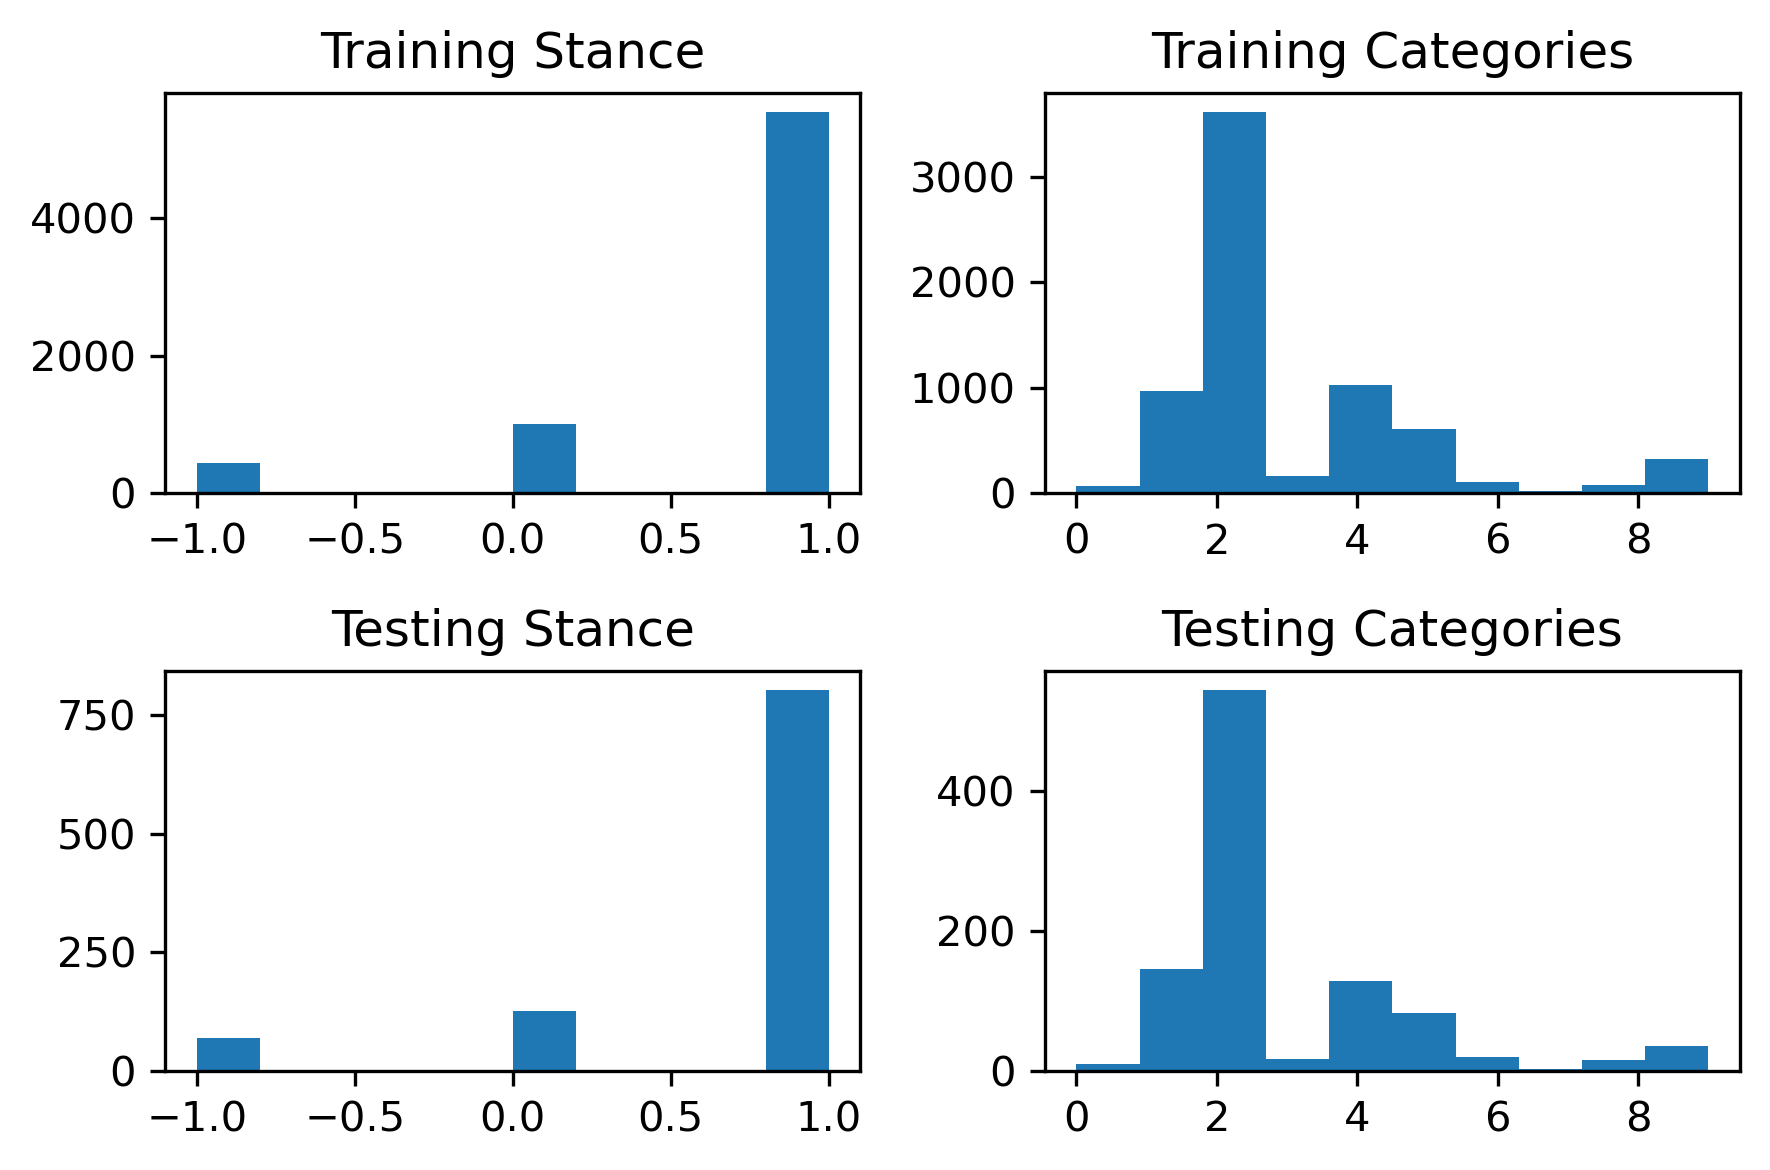

In [43]:
%run ../1-Preprocessing/DataInsight.ipynb import x, y1, y2, X, Y1, Y2
# convert y, Y from one-hot to integer (as will be assumed by the loss function later)
y1, y2 = np.argmax(y1, axis=1), np.argmax(y2, axis=1)
Y1, Y2 = np.argmax(Y1, axis=1), np.argmax(Y2, axis=1)

#### Imports

In [44]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

cpu


#### Loading the Preprocessed Data

In [46]:
train_data = TensorDataset(torch.from_numpy(x), torch.from_numpy(y2))
valid_data = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y2))

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=1024)

#### Creating the Model

In [47]:
class SequenceModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers, drop_prob=0.5):
        super().__init__()

        # Network Dimensions
        self.vocab_size, self.hidden_dim, self.output_dim  = vocab_size, hidden_dim, output_dim
        self.num_layers = num_layers
    
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Drop out layer
        self.dropout = nn.Dropout(0.3)
    
        # Output Layer
        self.output = nn.Linear(self.hidden_dim, output_dim)      # Or make it linear and use Sofrmax (in loss)
   
    def forward(self, x):
        
        embeds = self.embedding(x)                                          # B * Seq_Len * embedding_dim
        
        lstm_out, _ = self.lstm(embeds)                                     # B * Seq_Len * hidden_dim
        
        lstm_out =  lstm_out[:, -1, :]                                      # B * hidden_dim

        drop_out = self.dropout(lstm_out)                                   # B * hidden_dim

        
        out = self.output(drop_out)                                         # B * output_dim
        
        return out
        

#### Initializing the Model

In [48]:
num_layers = 1
vocab_size = 500
embedding_dim = 64
output_dim = 10
hidden_dim = 256


model = SequenceModel(vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers).to(device)

print(model)

SequenceModel(
  (embedding): Embedding(500, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=256, out_features=10, bias=True)
)


#### Training & Validating the Model

In [49]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
clip = 5
epochs = 5 
epoch_tr_loss, epoch_vl_loss = [], []

for epoch in range(epochs):
    train_losses = []
    for inputs, labels in tqdm(train_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)   
        
        output = model(inputs)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    val_losses = []
    for inputs, labels in valid_loader:
        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())

        if epoch == epochs-1:
            F1 = f1_score(labels.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro')
            
            
            
    
    epoch_tr_loss.append(np.mean(train_losses))
    epoch_vl_loss.append(np.mean(val_losses))
    print(f'Epoch {epoch+1}') 
    print(25*'==')

print("Macro F1 Score: ", F1)

100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


Epoch 1


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


Epoch 2


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


Epoch 3


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


Epoch 4


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


Epoch 5
Macro F1 Score:  0.07055016181229774


#### Loss and Accuracy

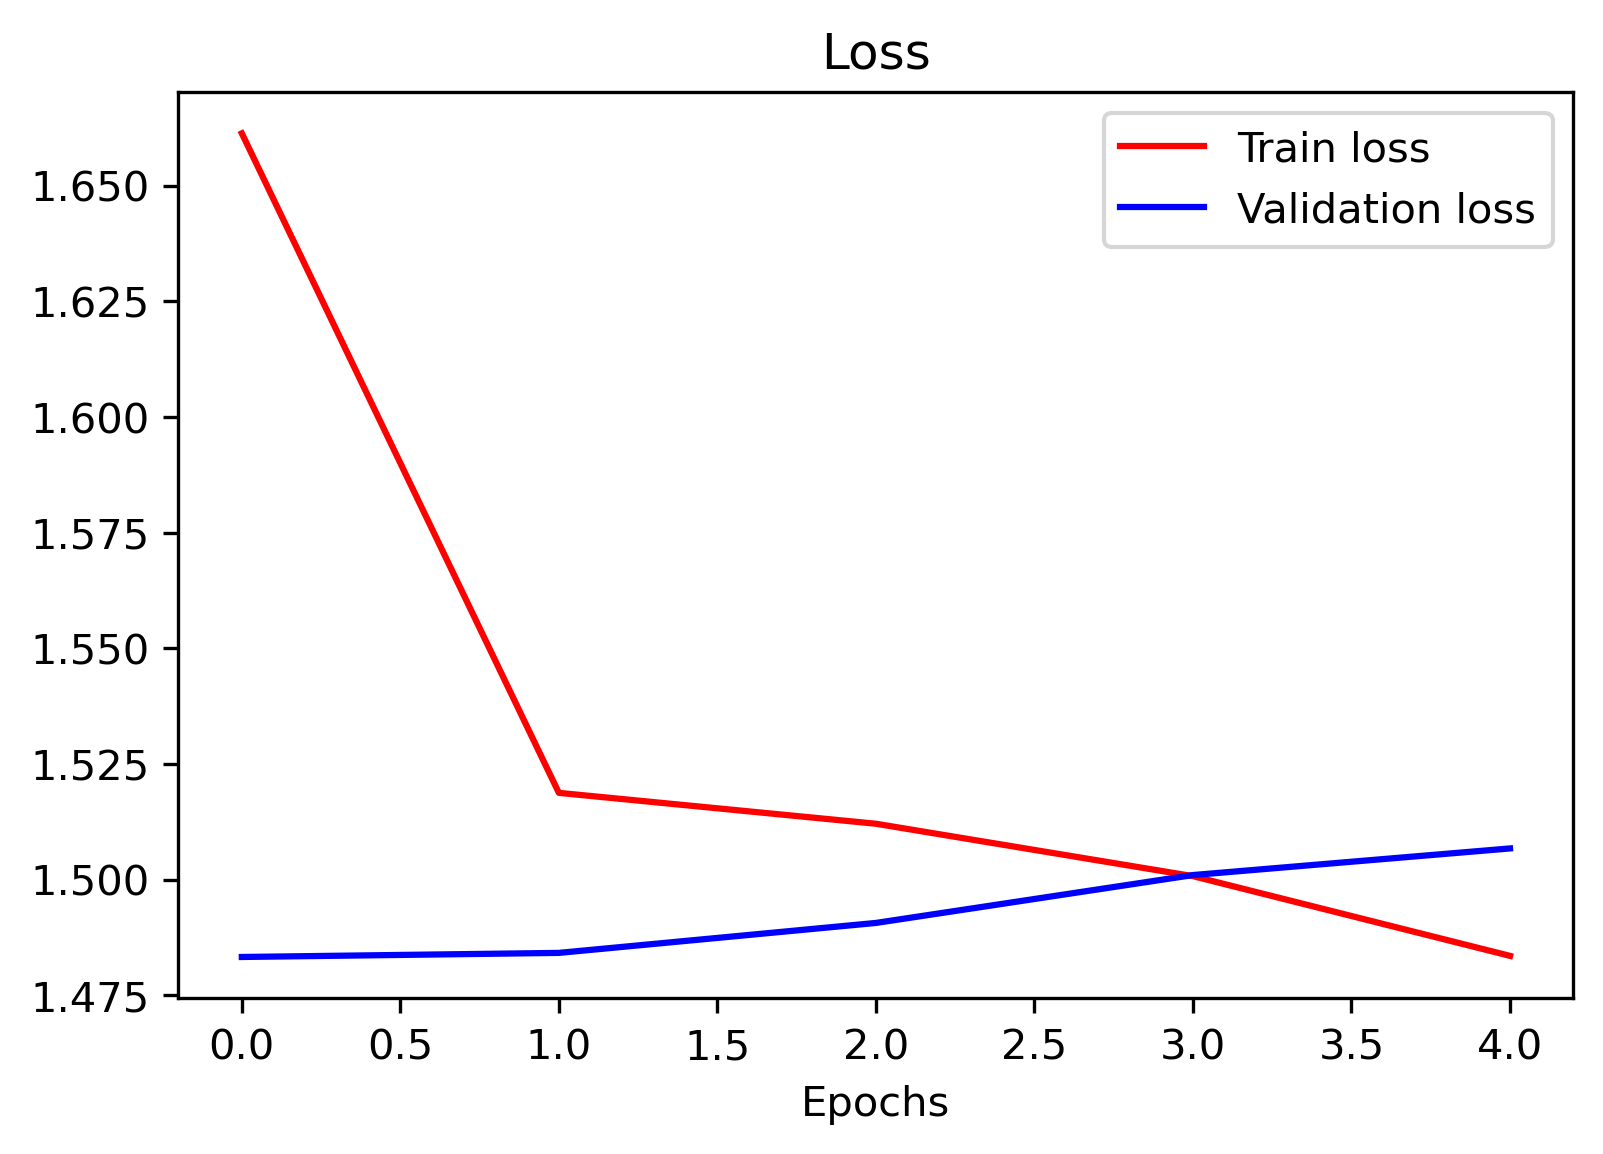

In [51]:
plt.plot(epoch_tr_loss, label='Train loss', color='red')
plt.plot(epoch_vl_loss, label='Validation loss', color='blue')
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()